In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## CLUPI optical distortion

Reference:

[CLUPI FM Geometric Calibration](./doc/CLUPI_FM_GeometricCalibration_20190805_V1.0.pdf)

[Open CV optical distortion]( https://docs.opencv.org/2.4/doc/tutorials/calib3d/camera_calibration/camera_calibration.html#camera-calibration-with-opencv)

<img src="./img/clupi_fovs.png" width="100" title="CLUPI context" />


In [2]:
width = 2652
half_width = width/2
height = 1768
half_height = height/2


calibration_results = {

'28' : {
   'distortion' : [
    0.90795278846644,
   -0.81549917806834,
   -0.015467154966426,
   -0.024081314487023,
   -0.021714843651652    
    ]
},


'100' : {
   'distortion' : [
    0.90795278846644,
     0.82640045036451,
    -0.80990580903775,
    -0.013565578400063,
    -0.024481529915831,
    -0.020481752564741
    ]
},

'120' : {
   'distortion' : [
    0.90795278846644,
     0.84478595905046,
    -0.77452686325751,
     0.016311335023569,
     0.013922403608605,
     0.040406969232604
    ]
}
}



[1084.12911517 1084.29825653 1084.46687629 1084.63497196 1084.80254109]
631.1688191431267
0.0


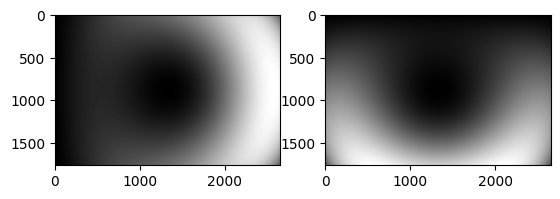

In [11]:

focal_distance = '28'
calibration = calibration_results[focal_distance]

k1, k2, p1, p2, k3 = calibration['distortion']

x, y = np.meshgrid(np.arange(0, width), np.arange(0, height))

mod_r = np.sqrt(np.power(half_width, 2) + np.power(half_height, 2))

r = np.sqrt(np.power(x-half_width, 2) + np.power(y-half_height, 2)) / mod_r 

rad_distortion_x = x * (1 + k1 * np.power(r, 2) + k2 * np.power(r, 4) + k3 * np.power(r, 6))
rad_distortion_y = y * (1 + k1 * np.power(r, 2) + k2 * np.power(r, 4) + k3 * np.power(r, 6))

tan_distortion_x = (2 * p1 * x * y) + p2 * (np.power(r, 2) + (2 * np.power(x, 2)))

print(rad_distortion_x[-5:, int(half_height)])
# print(rad_dist_x[0:5,0:5])
# print(r[0:5,0:5])

hor_dist = rad_distortion_x  - x
ver_dist = rad_distortion_y - y

print(np.max(hor_dist))
print(np.min(hor_dist))
cmap_name = 'gray'
fig, (subplot_1, subplot_2) = plt.subplots(1, 2)
subplot_1.imshow(hor_dist, cmap=cmap_name)
subplot_2.imshow(ver_dist, cmap=cmap_name)
